# Mortgage PD scorecard

## Import libraries

In [202]:
%reset

In [203]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Step 1: Data Preparation

### Step 1.1: Data Loading

In [204]:
# Load the dataset
file_path = "data/mortgage_sample.csv"  # replace with the actual path or URL
df_raw = pd.read_csv(file_path)

In [205]:
df_raw.head()

,id,time,orig_time,first_time,mat_time,balance_time,LTV_time,interest_rate_time,hpi_time,gdp_time,...,investor_orig_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,default_time,payoff_time,status_time,sample
0,1,25,-7,25,113,41303.42,24.498336,9.2,226.29,2.899137,...,0,45000.0,715,69.4,9.2,87.03,0.0,0.0,0.0,public
1,1,26,-7,25,113,41061.95,24.483867,9.2,225.10,2.151365,...,0,45000.0,715,69.4,9.2,87.03,0.0,0.0,0.0,public
2,1,27,-7,25,113,40804.42,24.626795,9.2,222.39,2.361722,...,0,45000.0,715,69.4,9.2,87.03,0.0,0.0,0.0,public
3,1,28,-7,25,113,40483.89,24.735883,9.2,219.67,1.229172,...,0,45000.0,715,69.4,9.2,87.03,0.0,0.0,0.0,public
4,1,29,-7,25,113,40367.06,24.925476,9.2,217.37,1.692969,...,0,45000.0,715,69.4,9.2,87.03,0.0,0.0,0.0,public


In [206]:
# Display basic information about the dataset
print("\nDataset Information:")
df_raw.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622489 entries, 0 to 622488
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       622489 non-null  int64  
 1   time                     622489 non-null  int64  
 2   orig_time                622489 non-null  int64  
 3   first_time               622489 non-null  int64  
 4   mat_time                 622489 non-null  int64  
 5   balance_time             622489 non-null  float64
 6   LTV_time                 622219 non-null  float64
 7   interest_rate_time       622489 non-null  float64
 8   hpi_time                 622489 non-null  float64
 9   gdp_time                 622489 non-null  float64
 10  uer_time                 622489 non-null  float64
 11  REtype_CO_orig_time      622489 non-null  int64  
 12  REtype_PU_orig_time      622489 non-null  int64  
 13  REtype_SF_orig_time      622489 non-n

In [207]:
# Filter out private observations
df_public = df_raw[df_raw['sample'] == 'public']
df_public = df_public.drop(['sample'], axis=1)

#### IDEA: filter out ids which end with status code 0. It means that the loan is still active and we don't know if it will default or not. We can't use this data for training.

In [208]:
filtered_ids = df_public.groupby('id')['status_time'].sum()[lambda x: x > 0].index
df_dev = df_public[df_public['id'].isin(filtered_ids)]

### Step 1.2: Data Exploration

In [209]:
# Display summary statistics
print("\nSummary Statistics:")
df_dev.describe()


Summary Statistics:


,id,time,orig_time,first_time,mat_time,balance_time,LTV_time,interest_rate_time,hpi_time,gdp_time,...,REtype_SF_orig_time,investor_orig_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,default_time,payoff_time,status_time
count,342027.000000,342027.000000,342027.000000,342027.000000,342027.000000,3.420270e+05,341971.000000,342027.000000,342027.000000,342027.000000,...,342027.000000,342027.000000,3.420270e+05,342027.000000,342027.000000,342027.000000,342027.000000,342027.000000,342027.000000,342027.000000
mean,24568.108570,31.138162,20.059981,23.445421,136.700500,2.590125e+05,81.217144,7.054329,189.585114,1.410181,...,0.612972,0.127154,2.670999e+05,672.249667,79.143273,5.583407,196.079591,0.039833,0.070009,0.179851
std,13627.324103,9.393406,7.298112,6.014540,18.788973,2.216568e+05,23.538631,1.876843,29.075380,2.029758,...,0.487071,0.333146,2.275251e+05,71.950202,9.914621,3.106879,34.496150,0.195567,0.255163,0.536212
min,1.000000,1.000000,-40.000000,1.000000,23.000000,0.000000e+00,0.000000,0.000000,107.830000,-4.146711,...,0.000000,0.000000,0.000000e+00,400.000000,50.100000,0.000000,75.710000,0.000000,0.000000,0.000000
25%,13066.000000,25.000000,17.000000,20.000000,136.000000,1.117557e+05,66.091130,5.875000,161.000000,1.104163,...,0.000000,0.000000,1.160000e+05,624.000000,75.000000,4.875000,179.450000,0.000000,0.000000,0.000000
50%,24292.000000,30.000000,22.000000,24.000000,141.000000,1.963633e+05,79.944960,6.875000,188.370000,1.850689,...,1.000000,0.000000,2.000000e+05,675.000000,80.000000,6.300000,212.730000,0.000000,0.000000,0.000000
75%,36706.000000,37.000000,25.000000,28.000000,145.000000,3.563412e+05,97.400294,8.000000,217.370000,2.899137,...,1.000000,0.000000,3.680000e+05,728.000000,80.000000,7.500000,222.390000,0.000000,0.000000,0.000000
max,49984.000000,60.000000,60.000000,60.000000,229.000000,8.701859e+06,248.432000,37.500000,226.290000,5.132464,...,1.000000,1.000000,8.000000e+06,840.000000,178.600000,18.000000,226.290000,1.000000,1.000000,2.000000


#### New features

In [210]:
# balance orig time cannot be 0
df_dev = df_dev[df_dev['balance_orig_time'] > 0]

df_dev['time_until_mat'] = df_dev['mat_time'] - df_dev['time']
df_dev['balance_paid'] = df_dev['balance_orig_time'] - df_dev['balance_time']
df_dev['balance_paid_perc'] = df_dev['balance_paid'] / df_dev['balance_orig_time']

In [211]:
df_dev[['balance_orig_time', 'time_until_mat', 'balance_paid', 'balance_paid_perc']].describe()

,balance_orig_time,time_until_mat,balance_paid,balance_paid_perc
count,3.419710e+05,341971.000000,3.419710e+05,341971.000000
mean,2.671436e+05,105.564855,8.095067e+03,0.033554
std,2.275180e+05,19.284706,3.840212e+04,0.096449
min,6.246000e+03,1.000000,-7.018592e+05,-2.655358
25%,1.160000e+05,103.000000,2.716000e+01,0.000126
50%,2.000000e+05,111.000000,1.251710e+03,0.008270
75%,3.680000e+05,115.000000,5.378470e+03,0.030542
max,8.000000e+06,198.000000,2.251328e+06,1.000000


In [212]:
# Check for missing values
print("\nMissing Values:")
df_dev.isnull().sum()


Missing Values:


id                         0
time                       0
orig_time                  0
first_time                 0
mat_time                   0
balance_time               0
LTV_time                   0
interest_rate_time         0
hpi_time                   0
gdp_time                   0
uer_time                   0
REtype_CO_orig_time        0
REtype_PU_orig_time        0
REtype_SF_orig_time        0
investor_orig_time         0
balance_orig_time          0
FICO_orig_time             0
LTV_orig_time              0
Interest_Rate_orig_time    0
hpi_orig_time              0
default_time               0
payoff_time                0
status_time                0
time_until_mat             0
balance_paid               0
balance_paid_perc          0
dtype: int64

In [213]:
# Count the number of rows with missing values
null_rows = df_dev.isnull().any(axis=0)
print("\nNumber of rows with missing values:", null_rows.sum())


Number of rows with missing values: 0


In [214]:
# First, select numerical variables only
num_vars = df_dev.select_dtypes(include=['float64', 'int64']).drop(columns=['id']).columns

print("\nDescriptive statistics:")
df_dev[num_vars].describe()


Descriptive statistics:


,time,orig_time,first_time,mat_time,balance_time,LTV_time,interest_rate_time,hpi_time,gdp_time,uer_time,...,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,default_time,payoff_time,status_time,time_until_mat,balance_paid,balance_paid_perc
count,341971.000000,341971.000000,341971.000000,341971.000000,3.419710e+05,341971.000000,341971.000000,341971.000000,341971.000000,341971.000000,...,341971.000000,341971.000000,341971.000000,341971.000000,341971.000000,341971.000000,341971.000000,341971.000000,3.419710e+05,341971.000000
mean,31.138421,20.062254,23.445166,136.703276,2.590485e+05,81.217144,7.053682,189.582296,1.410152,6.083682,...,672.266420,79.142818,5.583249,196.091687,0.039825,0.070006,0.179837,105.564855,8.095067e+03,0.033554
std,9.393946,7.296521,6.015000,18.787551,2.216570e+05,23.538631,1.876209,29.075080,2.029818,1.875841,...,71.940207,9.914030,3.106386,34.485983,0.195548,0.255157,0.536198,19.284706,3.840212e+04,0.096449
min,1.000000,-40.000000,1.000000,23.000000,0.000000e+00,0.000000,0.000000,107.830000,-4.146711,3.800000,...,400.000000,50.100000,0.000000,75.710000,0.000000,0.000000,0.000000,1.000000,-7.018592e+05,-2.655358
25%,25.000000,17.000000,20.000000,136.000000,1.117887e+05,66.091130,5.875000,161.000000,1.104163,4.700000,...,624.000000,75.000000,4.875000,179.450000,0.000000,0.000000,0.000000,103.000000,2.716000e+01,0.000126
50%,30.000000,22.000000,24.000000,141.000000,1.963990e+05,79.944960,6.875000,188.370000,1.850689,5.000000,...,675.000000,80.000000,6.300000,212.730000,0.000000,0.000000,0.000000,111.000000,1.251710e+03,0.008270
75%,37.000000,25.000000,28.000000,145.000000,3.563815e+05,97.400294,8.000000,217.370000,2.899137,7.800000,...,728.000000,80.000000,7.500000,222.390000,0.000000,0.000000,0.000000,115.000000,5.378470e+03,0.030542
max,60.000000,60.000000,60.000000,229.000000,8.701859e+06,248.432000,37.500000,226.290000,5.132464,10.000000,...,840.000000,178.600000,18.000000,226.290000,1.000000,1.000000,2.000000,198.000000,2.251328e+06,1.000000


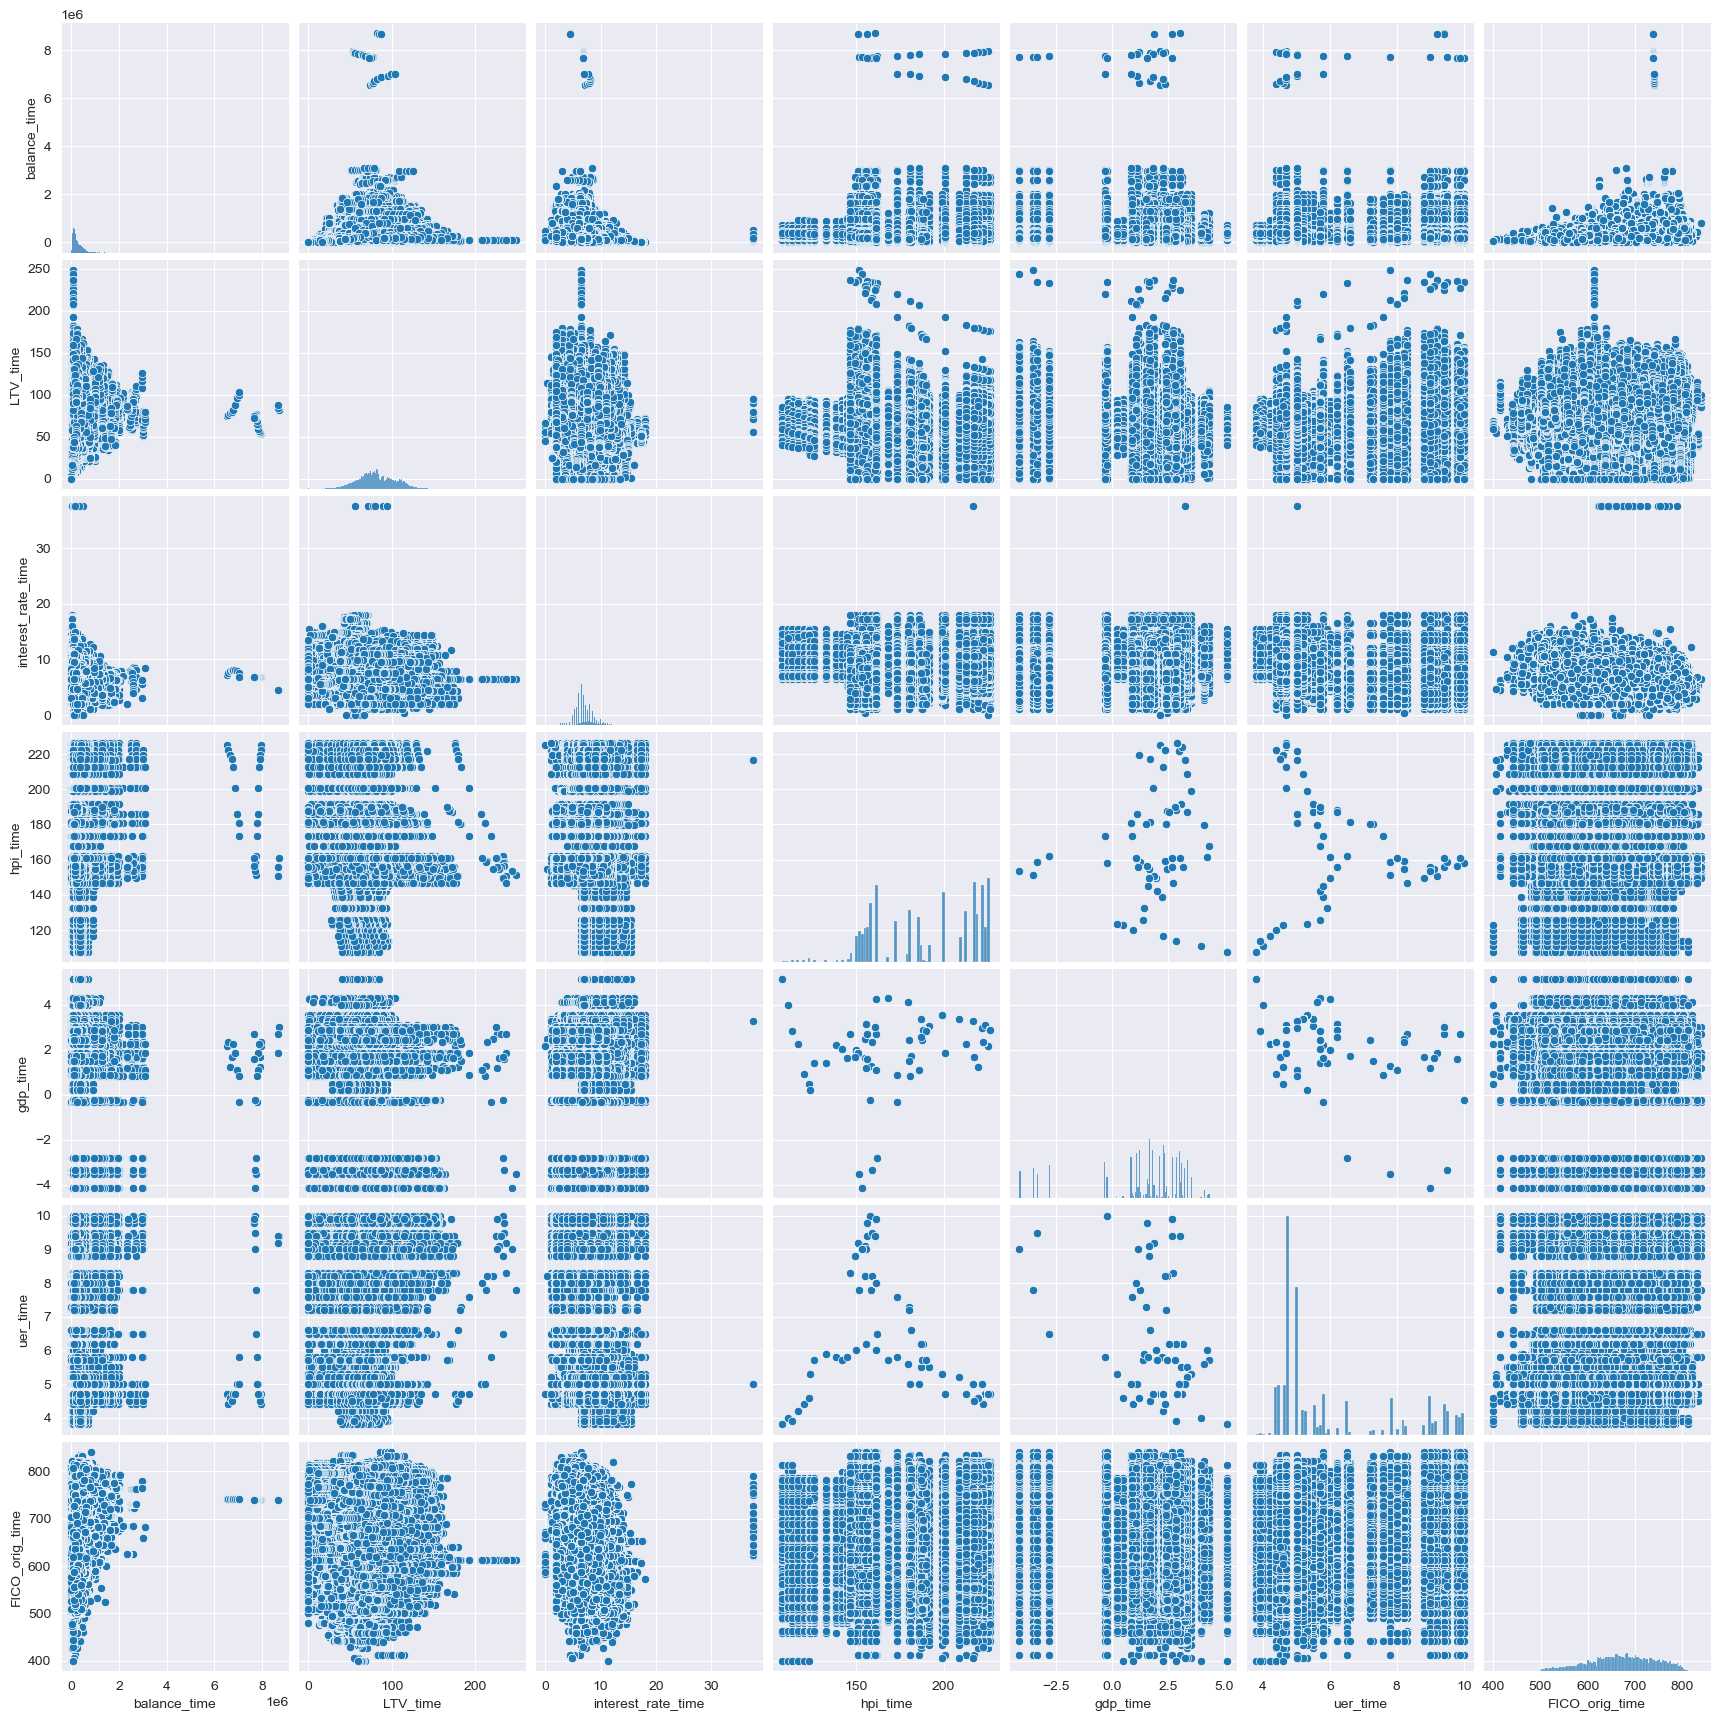

In [215]:
# Pairplot for numeric variables
sns.pairplot(df_dev[['balance_time', 'LTV_time', 'interest_rate_time', 'hpi_time', 'gdp_time', 'uer_time', 'FICO_orig_time']])
plt.show()


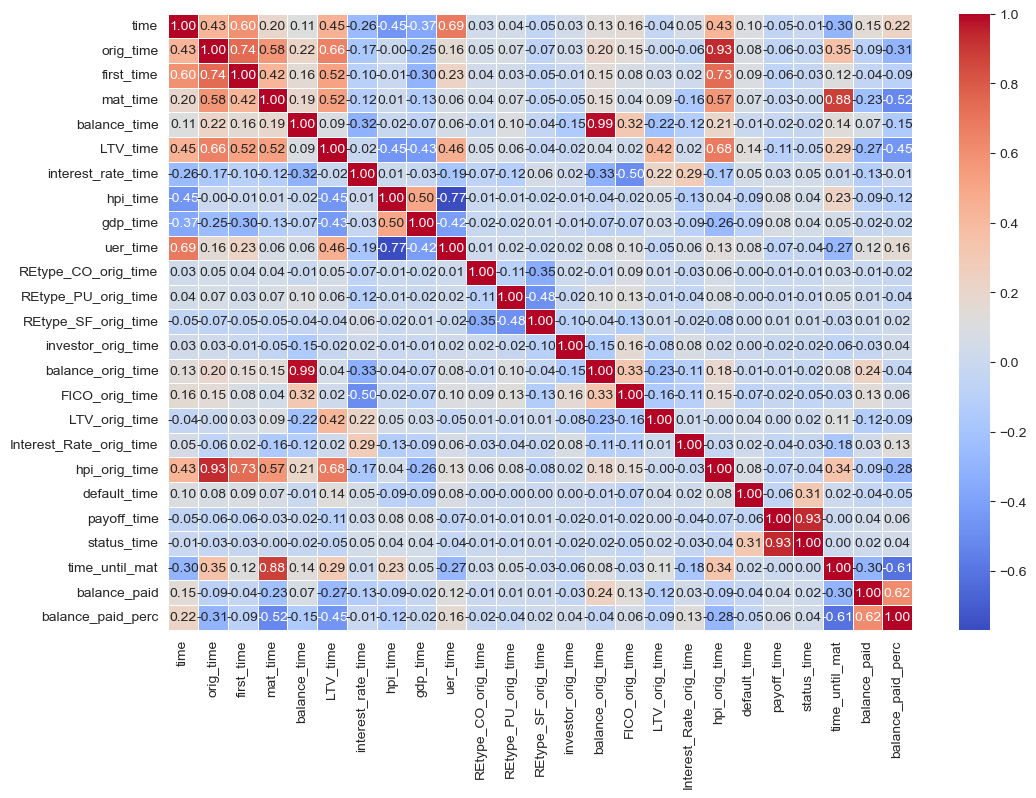

In [216]:
 # Correlation heatmap
correlation_matrix = df_dev.drop(columns=['id']).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()


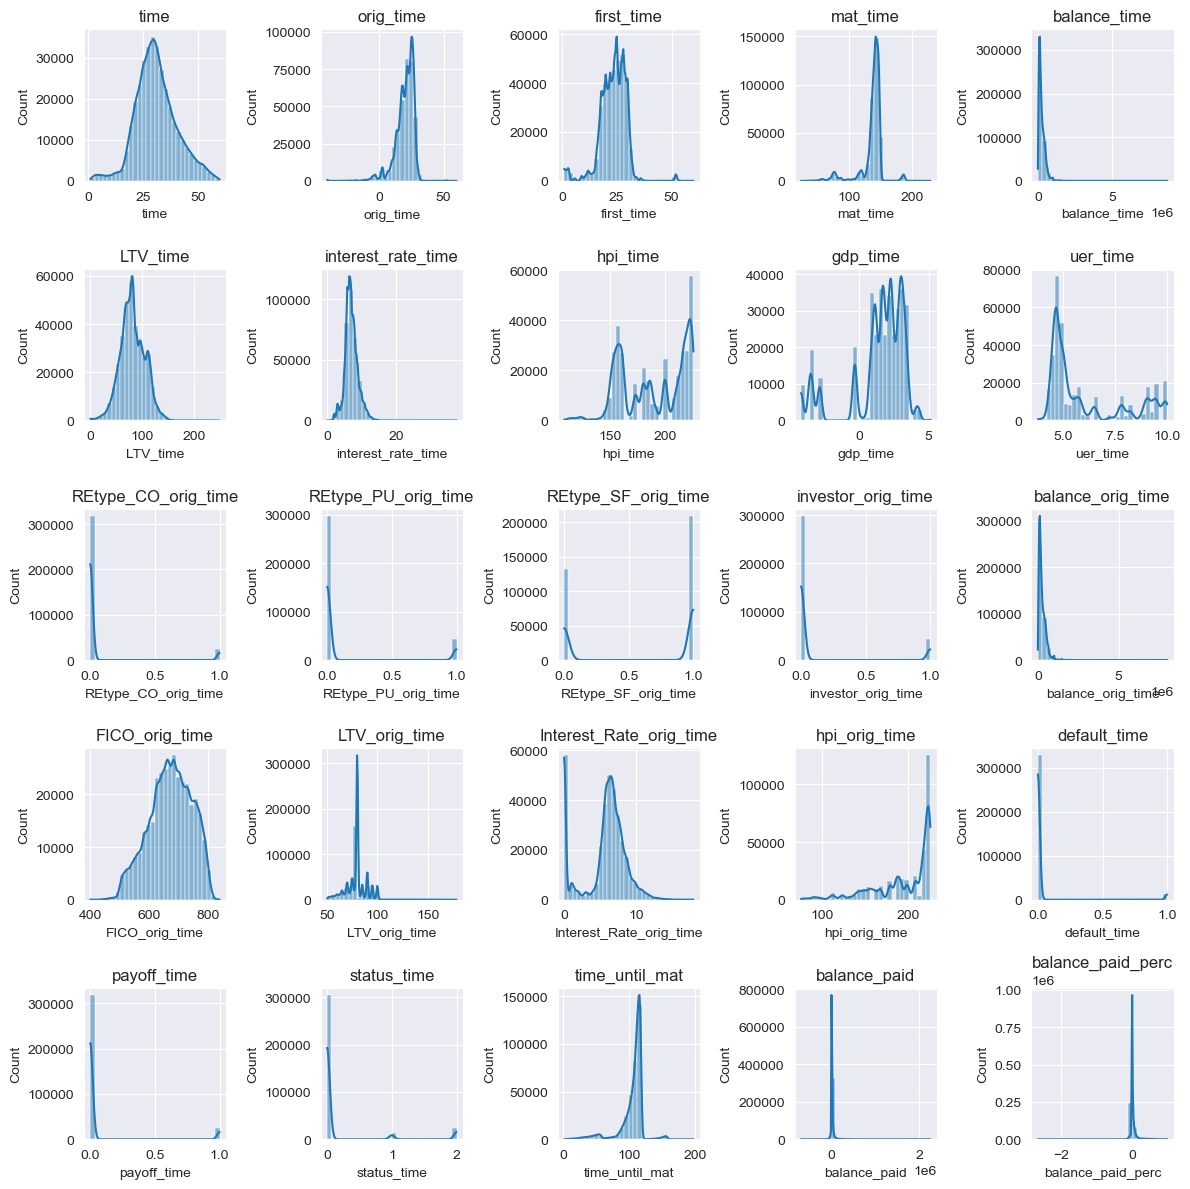

In [217]:
# Plot distributions
plt.figure(figsize=(12, 12))

for i, feature in enumerate(num_vars, 1):
    plt.subplot(5, 5, i)
    sns.histplot(df_dev[feature], bins=30, kde=True)
    plt.title(f'{feature}')
    plt.xlabel(feature)

plt.tight_layout()  # Add this line to prevent subplot overlap
plt.show()

In [218]:
# Group by home type and calculate the mean FICO score within each home type
home_type_fico_mean = df_dev.groupby(['REtype_SF_orig_time'])['FICO_orig_time'].mean()
print(home_type_fico_mean)

REtype_SF_orig_time
0    684.078220
1    664.806784
Name: FICO_orig_time, dtype: float64


In [219]:
# TODO: попробовать разные вариации с типом домов и мб другими переменными (пример выше из docs/mortgage_data_inspection.py)

### Step 1.3: Target construction

In [220]:
# TODO: для начала нужно выбрать кохорт, от какого месяца будем проверять клиентов. Далее разделить тайм по кохорте, и если клиент в это время дефолтил, то он дефолтил в этой кохорте, это может быть 1 или больше месяцев (до 12)

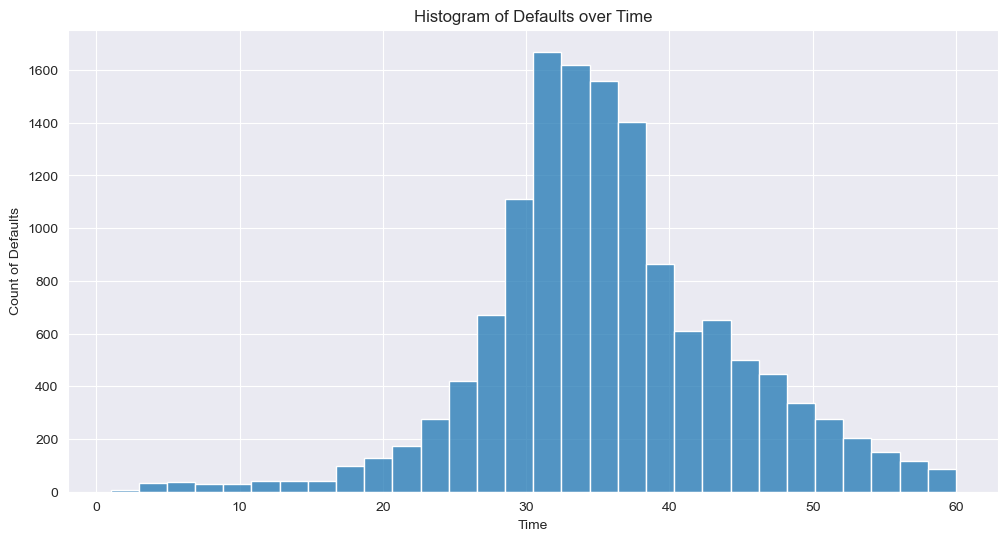

In [221]:
plt.figure(figsize=(12, 6))
sns.histplot(df_dev[df_dev['default_time'] == 1]['time'], bins=30, kde=False)
plt.title('Histogram of Defaults over Time')
plt.xlabel('Time')
plt.ylabel('Count of Defaults')
plt.show()

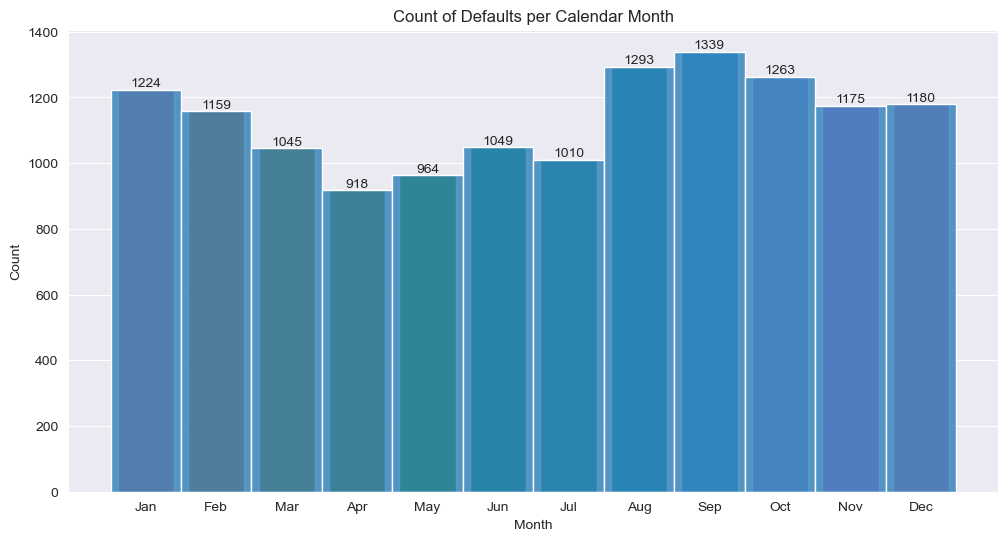

In [222]:
df_dev['calendar_month'] = df_dev['time'] % 12  # Extract the month from the 'time' column

# Filter data where 'default_time' is 1
default_df = df_dev[df_dev['default_time'] == 1]
count_per_month = default_df['calendar_month'].value_counts().sort_index()

# Plot histogram
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=count_per_month.index, y=count_per_month.values)
sns.histplot(default_df['calendar_month'], bins=range(13), kde=False, discrete=True)
plt.title('Count of Defaults per Calendar Month')
plt.xlabel('Calendar Month')
plt.ylabel('Count')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

for i, value in enumerate(count_per_month.values):
    ax.text(i, value + 0.1, str(value), ha='center', va='bottom')
    
plt.show()

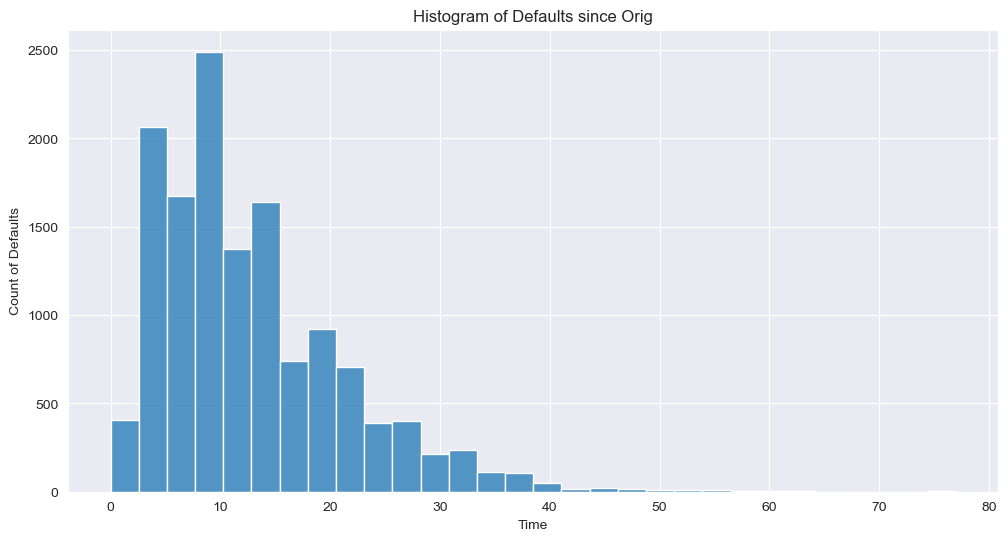

In [223]:
df_dev['time_since_orig'] = df_dev['time'] - df_dev['orig_time']

plt.figure(figsize=(12, 6))
sns.histplot(df_dev[df_dev['default_time'] == 1]['time_since_orig'], bins=30, kde=False)
plt.title('Histogram of Defaults since Orig')
plt.xlabel('Time')
plt.ylabel('Count of Defaults')
plt.show()

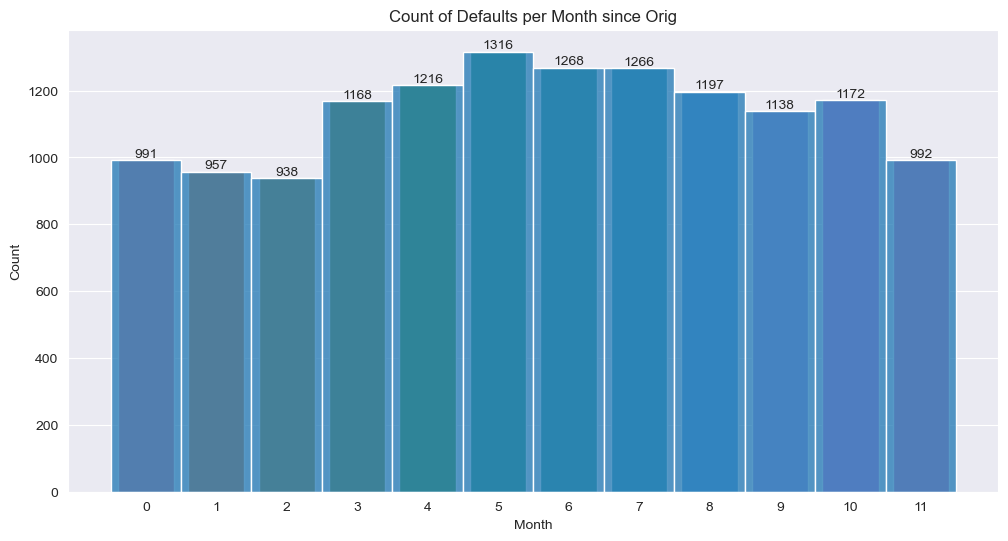

In [224]:
df_dev['month_since_orig'] = df_dev['time_since_orig'] % 12  # Extract the month from the 'time' column

# Filter data where 'default_time' is 1
default_df = df_dev[df_dev['default_time'] == 1]
count_per_month = default_df['month_since_orig'].value_counts().sort_index()

# Plot histogram
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=count_per_month.index, y=count_per_month.values)
sns.histplot(default_df['month_since_orig'], bins=range(13), kde=False, discrete=True)
plt.title('Count of Defaults per Month since Orig')
plt.xlabel('Month')
plt.ylabel('Count')

for i, value in enumerate(count_per_month.values):
    ax.text(i, value + 0.1, str(value), ha='center', va='bottom')

plt.show()